## Crater Ejecta Classifier

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Importing  all the necessary packages. This uses [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163), and is built from the first example in the fastai course.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import csv, random, shutil, glob, os

Reminder that changing bs (batch size) will help with my lousy GPUs. If getting an out of memory error when running this notebook: click Kernel->Restart and change bs.

In [3]:
# bs = 64
 bs = 16   

## Loading the data

I have made a csv file tagging 30000+ craters for the visibility of ejecta.  However, it will be interesting to see if deep learning can do something similar, and how much training is needed.

In [4]:
amtdataperclass=1800
amtvalperclass=900
#setup the number of images from which to try building the model.  
#The maximum possible sum of these is ~3000 (the number of ejecta craters mapped).

In [5]:
csvdatafile='D:/course-v3/WesClassifier/ClassifiedCratersJoined.csv'

In [6]:
listofejecta=[]
listofnoejecta=[]
# define lists of different classes

In [7]:
with open(csvdatafile) as csvfile:
    reader=csv.DictReader(csvfile)
    for row in reader:
        if row['ejecta']=='Y':
            listofejecta.append(row)
        else:
            listofnoejecta.append(row)

In [8]:
print(len(listofejecta))

3025


In [9]:
datapathej = 'D:/course-v3/WesClassifier/train/Ejecta'
datapathnoej = 'D:/course-v3/WesClassifier/train/Noejecta'
valpathej = 'D:/course-v3/WesClassifier/valid/Ejecta'
valpathnoej = 'D:/course-v3/WesClassifier/valid/Noejecta'

shutil.rmtree(datapathej, ignore_errors=True)
shutil.rmtree(datapathnoej, ignore_errors=True)
shutil.rmtree(valpathej, ignore_errors=True)
shutil.rmtree(valpathnoej, ignore_errors=True)
os.makedirs(datapathej)
os.makedirs(datapathnoej)
os.makedirs(valpathej)
os.makedirs(valpathnoej)

In [10]:
#choose random sample of ejecta and no ejecta images for training and val, of lengths specified above.
ejectadatasample=random.sample(listofejecta,amtdataperclass)
ejectavalsample=random.sample(listofejecta,amtvalperclass)

noejectadatasample=random.sample(listofnoejecta,amtdataperclass)
noejectavalsample=random.sample(listofnoejecta,amtvalperclass)

#copy all data over.  yes, i know, ugly
for el in noejectavalsample:
    posspaths=[]
    posspaths=posspaths+(glob.glob(el['posspath1']))
    posspaths=posspaths+(glob.glob(el['posspath2']))
    for a in posspaths:
        b=(a.replace('\\','/'))
        filesize=os.path.getsize(b)
        if filesize>0:
            shutil.copy(b,valpathnoej)
for el in ejectavalsample:
    posspaths=[]
    posspaths=posspaths+(glob.glob(el['posspath1']))
    posspaths=posspaths+(glob.glob(el['posspath2']))
    for a in posspaths:
        b=(a.replace('\\','/'))
        filesize=os.path.getsize(b)
        if filesize>0:
            shutil.copy(b,valpathej)
for el in ejectadatasample:
    posspaths=[]
    posspaths=posspaths+(glob.glob(el['posspath1']))
    posspaths=posspaths+(glob.glob(el['posspath2']))
    for a in posspaths:
        b=(a.replace('\\','/'))
        filesize=os.path.getsize(b)
        if filesize>0:
            shutil.copy(b,datapathej)
for el in noejectadatasample:
    posspaths=[]
    posspaths=posspaths+(glob.glob(el['posspath1']))
    posspaths=posspaths+(glob.glob(el['posspath2']))
    for a in posspaths:
        b=(a.replace('\\','/'))
        filesize=os.path.getsize(b)
        if filesize>0:
            shutil.copy(b,datapathnoej)
        

In [11]:
tfms=get_transforms(xtra_tfms=zoom_crop(scale=1.6,do_rand=False))

In [12]:
data = ImageDataBunch.from_folder('D:/course-v3/WesClassifier/',size=224,ds_tfms=tfms).normalize(imagenet_stats)

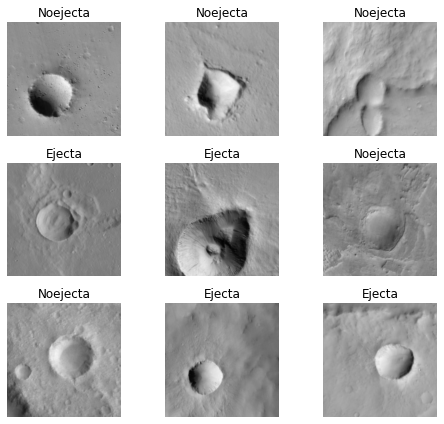

In [13]:
data.show_batch(rows=3, figsize=(7,6))

## Training: resnet34

start training our model.

In [14]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [15]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [16]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.802668,0.811095,0.296605,03:08
1,0.632244,0.541683,0.253756,03:00
2,0.500501,0.525305,0.252087,03:00
3,0.435597,0.506774,0.246522,02:59


In [17]:
learn.save('stage-1')

## Results

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

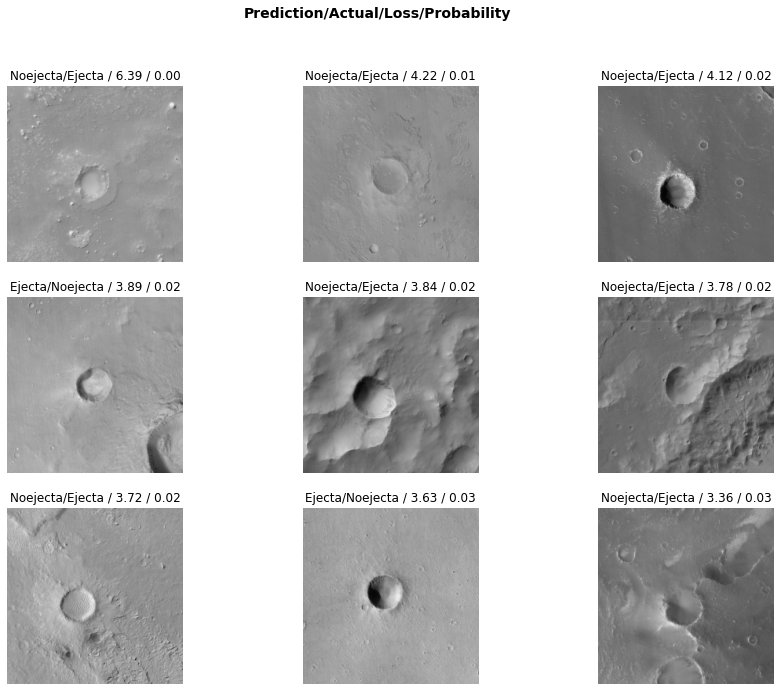

In [19]:
interp.plot_top_losses(9, figsize=(15,11))

In [20]:
doc(interp.plot_top_losses)

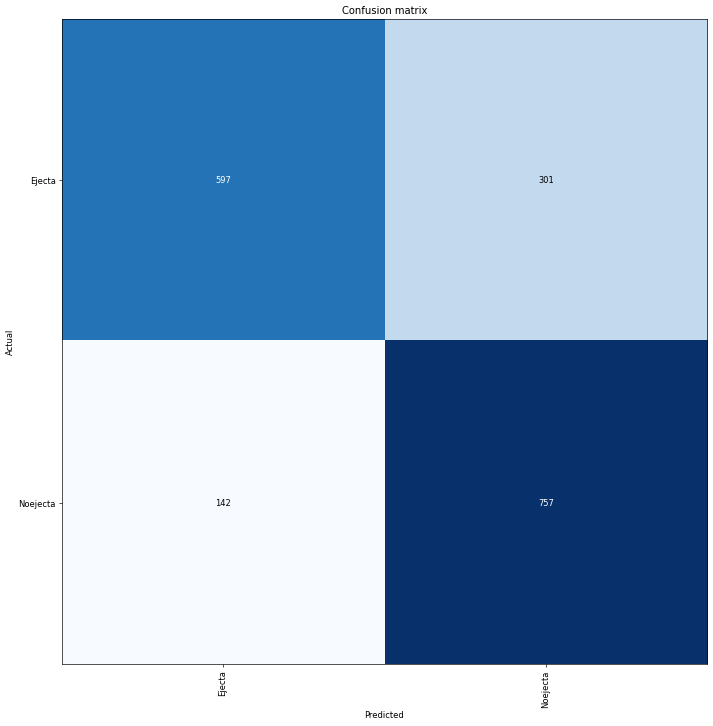

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
interp.most_confused(min_val=2)

[('Ejecta', 'Noejecta', 301), ('Noejecta', 'Ejecta', 142)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


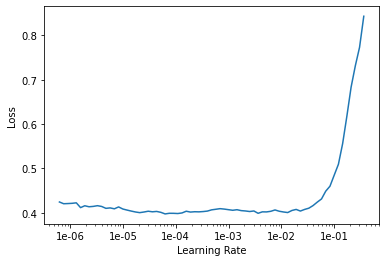

In [24]:
learn.recorder.plot()

In [25]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(5e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.395394,0.563794,0.251530,03:19
1,0.346849,0.514156,0.262103,03:17
2,0.284479,0.514167,0.233166,03:18
3,0.227355,0.402118,0.185865,03:19
